# Exercise Classification during walking, running and biking

## Summary

This project make use of the "Wrist PPG During Exercise" dataset in physionet

https://physionet.org/content/wrist/1.0.0/

This dataset contains wrist PPGs, accelerometers and gyroscopes recorded during walking, running and bike riding. The data was recorded from 8 participants (3 male, 5 female), aged 22--32 (mean 26.5). 

This project is only using the accelerometers data to classify activities between walking, running and low resistance biking only.

## Data Exploration 

First let's explore the data...

### Imports

In [1]:
import collections
import glob
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import seaborn as sns

### Examine The Files

In [4]:
data_dir = 'data/'
filenames = [os.path.splitext(f)[0] for f in sorted(os.listdir(data_dir))]
fs = 256
print('Number of files: ' + str(len(filenames)))
filenames

Number of files: 17


['s1_bike_0',
 's1_bike_1',
 's1_walk',
 's2_bike_0',
 's2_bike_1',
 's2_walk',
 's3_bike_0',
 's3_bike_1',
 's3_run',
 's3_walk',
 's4_run',
 's5_run',
 's6_run',
 's6_walk',
 's8_run',
 's8_walk',
 's9_walk']

In [11]:
subjects_per_class = collections.defaultdict(set)
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)
    
{k: len(v) for k, v in subjects_per_class.items()}

{'bike': 3, 'walk': 6, 'run': 5}

In summary, we have 17 files organized by subject_activity.  

Some subjects have two bike datasets  
First 2 subjects have no run  
S3 is the only one that has all 4 classes  
S4 and S5 only have run  
S6 and S8 don't have bike  
S9 only has walk

The main concerns are
1. The number of subjects is low (N=8)
2. Not all subjects have performed all 3 activities with an imbalance in terms of number of representation of each class per subject. Thish may leads to some problems during the leave-one-subject-out cross validation. Our models could be biased towards the class that occurs more often in the training set. 

 

### Load the data

In [5]:
subjects_per_class = collections.defaultdict(set)
# data creates a list of [subject, activity, accelerometer data]
data = []
# df_data will hold the restructured data in a single dataframe table
# to be used with seaborn plotting functions
df_data = [] 
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)
    path = os.path.join(data_dir, f + '.csv')
    df = pd.read_csv(path)
    df = df.loc[: df.last_valid_index()]
    data.append((subject, activity, df))
    df_tmp = pd.melt(df,var_name='directions',value_name='acc')
    df_tmp = pd.concat([pd.DataFrame({'subject': np.repeat(subject,len(df_tmp)),'activity': np.repeat(activity,len(df_tmp))}),
                        df_tmp],axis=1)
    if len(df_data)==0:
        df_data=df_tmp
    else: 
        df_data = pd.concat([df_data,df_tmp],ignore_index='True')
    


DescribeResult(nobs=17, minmax=(3.65, 9.8), mean=6.087051930147059, variance=3.701484939724792, skewness=1.0699974180917178, kurtosis=-0.14716069171995239)

Provide a descriptive statistics on the duration of the recordings

In [13]:
# descriptive stats on duration of each recording
print(sp.stats.describe([len(df[2])/60/fs for df in data]))

 
df.head()

This gives descriptive on duration of recordings:

DescribeResult(nobs=17, minmax=(3.65, 9.8), mean=6.087051930147059, variance=3.701484939724792, skewness=1.0699974180917178, kurtosis=-0.14716069171995239)


,accx,accy,accz
0,3.791152,-9.329793,1.622757
1,3.791152,-9.329285,1.646969
2,3.791366,-9.304383,1.695834
3,3.767274,-9.267029,1.732482
4,3.780279,-9.194481,1.770231


Each Recording is about 4-10 min long!

Plot the number of datapoints per class to get a better idea of the class imbalance.

In [16]:
%matplotlib inline

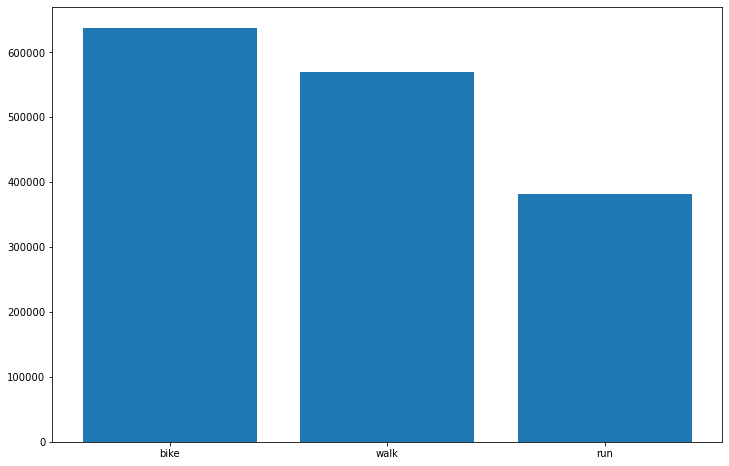

In [20]:
samples_per_class = collections.defaultdict(int)
for subject, activity, df in data:
    samples_per_class[activity] += len(df)
    

activity, n_samples = list(zip(*samples_per_class.items()))
plt.figure(figsize=(6, 4))
plt.bar(range(3), n_samples)
plt.xticks(range(3), activity);
plt.title('Number of samples per activity')

Plot distribution of the data

<Figure size 432x288 with 0 Axes>

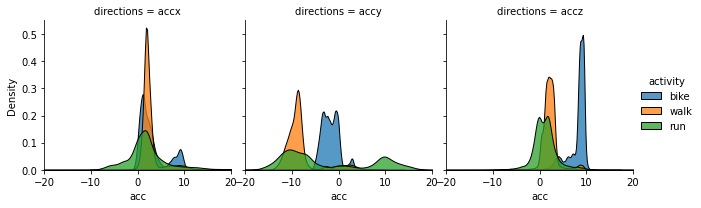

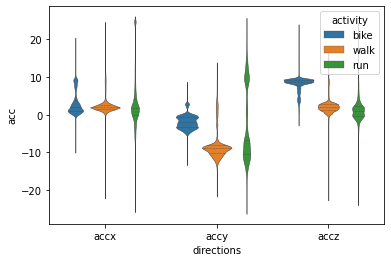

In [14]:
# Plotting by combining subjects data
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(df_data.drop(columns=["subject"]), col="directions", hue="activity")
g.map(sns.kdeplot, "acc", multiple="stack")
g.add_legend()
g.set(xlim=(-20, 20))

plt.figure(figsize=(6, 4))
ax = sns.violinplot(x="directions", y="acc", hue="activity",
                    data=df_data.drop(columns=["subject"]),inner='quartile', width=0.8, linewidth=0.5)


## Plotting the Raw Data

Using magic function to have an interactive plot. Then plot data for each recordings; must press a key to go to next recording

In [15]:
%matplotlib auto


Using matplotlib backend: Qt5Agg


In [16]:
for subject, activity, df in sorted(data, key=lambda x: x[1]):
    ts = np.arange(len(df)) / fs
    plt.clf() 
    plt.plot(ts, df.accx, label='x')
    plt.plot(ts, df.accy, label='y')
    plt.plot(ts, df.accz, label='z')
    plt.title('{}_{}'.format(subject, activity))
    plt.legend()
    plt.ylim((-25, 25))
    plt.draw() 
    plt.show()
    #plt.pause(10)
    # wait for user input (key); can still use mouse button
    while not plt.waitforbuttonpress(timeout=1):
        pass

 For some recordings, data shows large discontinuity as the data distribution plots above seems to suggest. High pass filtering may be necessary and features may need to be independent of offset/mean